In [3]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

NEO4J_USER = os.getenv("NEO4J_USER")
NEO4J_PASSWORD = os.getenv("NEO4J_PASS")
openai_api_key = os.getenv("openai_api_key")

In [ ]:
from google.cloud import bigquery
client = bigquery.Client()


admission_query = """
WITH eligible_patients AS (
  SELECT subject_id
  FROM `physionet-data.mimiciii_clinical.admissions`
  GROUP BY subject_id
  HAVING COUNT(DISTINCT hadm_id) BETWEEN 1 AND 3
),
sampled_patients AS (
  SELECT subject_id
  FROM eligible_patients
  ORDER BY RAND()
  LIMIT 1000
)
SELECT a.*
FROM `physionet-data.mimiciii_clinical.admissions` a
JOIN sampled_patients s ON a.subject_id = s.subject_id
WHERE a.hadm_id IS NOT NULL
"""

sampled_patients_admissions_df = client.query(admission_query).to_dataframe()

# Formating the date columns
sampled_patients_admissions_df['ADMITTIME'] = pd.to_datetime(sampled_patients_admissions_df['ADMITTIME'])  
sampled_patients_admissions_df['DISCHTIME'] = pd.to_datetime(sampled_patients_admissions_df['DISCHTIME'])  

# Flag readmissions within 30 days
sampled_patients_admissions_df = sampled_patients_admissions_df.sort_values(["SUBJECT_ID", "ADMITTIME"])
sampled_patients_admissions_df["NEXT_ADMITTIME"] = sampled_patients_admissions_df.groupby("SUBJECT_ID")["ADMITTIME"].shift(-1)
sampled_patients_admissions_df["DAYS_TO_NEXT"] = (sampled_patients_admissions_df["NEXT_ADMITTIME"] - sampled_patients_admissions_df["DISCHTIME"]).dt.days
sampled_patients_admissions_df["READMIT_30D"] = sampled_patients_admissions_df["DAYS_TO_NEXT"].apply(lambda x: 1 if 0 < x <= 30 else 0).fillna(0).astype(int)


sampled_hadm_ids = sampled_patients_admissions_df["HADM_ID"].unique().tolist()
sampled_patient_ids = sampled_patients_admissions_df['SUBJECT_ID'].unique().tolist()

# Convert list of Subject and HADM IDs into a SQL IN clause
id_list_str = ", ".join(str(x) for x in sampled_patient_ids)
id_filter = f"({id_list_str})"

hadm_list_str = ", ".join(str(x) for x in sampled_hadm_ids)
hadm_filter = f"({hadm_list_str})"


In [106]:

patient_query = """
SELECT *
FROM `physionet-data.mimiciii_clinical.patients` p
WHERE p.subject_id IN {id_filter}
"""
# Download the sampled patients data to CSV
sampled_patients_df = client.query(patient_query.format(id_filter=id_filter)).to_dataframe()
sampled_patients_df.to_csv("./neo4j-community-2025.03.0/import/patients.csv", index=False)

# Add AGE column to admissions dataframe
sampled_patients_admissions_df = sampled_patients_admissions_df.merge(sampled_patients_df[["SUBJECT_ID", "DOB"]], on="SUBJECT_ID", how="left")

# Compute age at admission; Account for MIMIC III obfuscation of ages over 89
sampled_patients_admissions_df["AGE"] = (sampled_patients_admissions_df["ADMITTIME"] - sampled_patients_admissions_df["DOB"]).dt.days // 365
sampled_patients_admissions_df["AGE"] = sampled_patients_admissions_df["AGE"].apply(lambda x: 89 if x > 200 else x)

# Drop DOB column after use
sampled_patients_admissions_df = sampled_patients_admissions_df.drop(columns=["DOB"])

# Download the sampled admissions data to CSV
sampled_patients_admissions_df.to_csv("./neo4j-community-2025.03.0/import/admissions.csv", index=False)

/Users/abemankavil/Desktop/MS in AI/AI395T-AIinHealthcare/HighRisk_Project/HighRiskEnv/lib/python3.9/site-packages/google/cloud/bigquery/table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [107]:
diag_query = """
SELECT d.subject_id, d.hadm_id, d.icd9_code, icd.short_title AS diagnosis
FROM `physionet-data.mimiciii_clinical.diagnoses_icd` d
JOIN `physionet-data.mimiciii_clinical.d_icd_diagnoses` icd
  ON d.icd9_code = icd.icd9_code
WHERE d.hadm_id IN {hadm_filter}
"""

diag_df = client.query(diag_query.format(hadm_filter=hadm_filter)).to_dataframe()

diag_df.to_csv("./neo4j-community-2025.03.0/import/diagnoses.csv", index=False)

/Users/abemankavil/Desktop/MS in AI/AI395T-AIinHealthcare/HighRisk_Project/HighRiskEnv/lib/python3.9/site-packages/google/cloud/bigquery/table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [108]:
drug_query = """
SELECT subject_id, hadm_id, drug, route, startdate, enddate, dose_val_rx, dose_unit_rx
FROM `physionet-data.mimiciii_clinical.prescriptions`
WHERE hadm_id IN {hadm_filter}
AND drug IS NOT NULL
"""

drug_df = client.query(drug_query.format(hadm_filter=hadm_filter)).to_dataframe()
drug_df.to_csv("./neo4j-community-2025.03.0/import/prescriptions.csv", index=False)


/Users/abemankavil/Desktop/MS in AI/AI395T-AIinHealthcare/HighRisk_Project/HighRiskEnv/lib/python3.9/site-packages/google/cloud/bigquery/table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [109]:
lab_query = """
SELECT le.subject_id, le.hadm_id, le.charttime, d.label AS lab_name, le.valuenum, le.valueuom
FROM `physionet-data.mimiciii_clinical.labevents` le
JOIN `physionet-data.mimiciii_clinical.d_labitems` d
  ON le.itemid = d.itemid
WHERE le.hadm_id IN {hadm_filter}
AND le.valuenum IS NOT NULL

"""

lab_df = client.query(lab_query.format(hadm_filter=hadm_filter)).to_dataframe()
lab_df.to_csv("./neo4j-community-2025.03.0/import/labevents.csv", index=False)

/Users/abemankavil/Desktop/MS in AI/AI395T-AIinHealthcare/HighRisk_Project/HighRiskEnv/lib/python3.9/site-packages/google/cloud/bigquery/table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [1]:
from neo4j import GraphDatabase
from langchain.graphs import Neo4jGraph
from langchain.chat_models import ChatOpenAI
from langchain.chains import GraphCypherQAChain
from sklearn.ensemble import IsolationForest
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
from openai import OpenAI
from graphdatascience import GraphDataScience
import seaborn as sns   


/Users/abemankavil/Desktop/MS in AI/AI395T-AIinHealthcare/EHR_Anomaly_Detection/HighRiskEnv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# ------------------------------
# Step 1: Neo4j + OpenAI Setup
# ------------------------------

NEO4J_URL = "bolt://localhost:7687"


# LangChain graph wrapper
graph_langchain = Neo4jGraph(
    url=NEO4J_URL,
    username=NEO4J_USER,
    password=NEO4J_PASSWORD
)

# Neo4j driver and GDS interface
gds = GraphDataScience(NEO4J_URL, auth=(NEO4J_USER, NEO4J_PASSWORD))

/var/folders/0r/lprjchvd593dyrpzsrg6jjrm0000gn/T/ipykernel_83891/3600210996.py:13: LangChainDeprecationWarning: The class `Neo4jGraph` was deprecated in LangChain 0.3.8 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-neo4j package and should be used instead. To use it run `pip install -U :class:`~langchain-neo4j` and import as `from :class:`~langchain_neo4j import Neo4jGraph``.
  graph_langchain = Neo4jGraph(


In [4]:
# ------------------------------
# Step 2: Generate Embeddings Using GDS Python Client
# ------------------------------

def generate_node2vec_embeddings():
    if gds.graph.exists("admission_subgraph").get("exists", False):
        gds.graph.drop("admission_subgraph")

    G, result = gds.graph.project(
        "admission_subgraph",
        node_spec={"Admission": {},
                    "Diagnosis": {},
                    "LabResult": {},
                    "Medication": {}},
        relationship_spec={
            "HAS_DIAGNOSIS": {"orientation": "UNDIRECTED"},
            "HAS_LAB": {"orientation": "UNDIRECTED"},
            "HAS_MEDICATION": {"orientation": "UNDIRECTED"}
        }
    )

    print(f"Projection created in {result['projectMillis']} ms")

    result = gds.node2vec.write(
    G,  # Graph object from projection
    writeProperty="embedding",  
    embeddingDimension=64,
    iterations=10,
    nodeLabels=["Admission"],  
    concurrency=4  
    )
    print(f"Node2Vec computed for {result['nodeCount']} nodes")

In [5]:
# ------------------------------
# Step 3: Fetch Embeddings from Neo4j
# ------------------------------

def get_admission_features():
    query = """
    MATCH (p:Patient)-[:HAS_ADMISSION]->(a:Admission)
    OPTIONAL MATCH (a)-[:HAS_MEDICATION]->(m:Medication)
    OPTIONAL MATCH (a)-[:HAS_LAB]->(l:LabResult)
    OPTIONAL MATCH (a)-[:HAS_DIAGNOSIS]->(d:Diagnosis)
    WHERE a.embedding IS NOT NULL
    RETURN a.HADM_ID AS hadm_id, a.embedding AS embedding, a.admission_type AS admission_type, a.diagnosis_free_text AS diagnosis,
           p.GENDER AS gender, a.ethnicity AS ethnicity, a.age AS age, a.hospital_expire_flag AS hospital_expire_flag, a.readmission_within_30days AS readmission_within_30days,
           collect(DISTINCT {name: m.DRUG, dose: m.dose, unit: m.unit}) AS meds, collect(DISTINCT {name: l.TEST_NAME, value: l.value, unit: l.unit}) AS labs, collect(DISTINCT d.CODE) AS diag_codes
    """
    result = gds.run_cypher(query)
    df = pd.DataFrame(result)
    df = df[df["embedding"].notnull()].copy()
    df["embedding"] = df["embedding"].apply(lambda x: [float(i) for i in x])
    return df


In [98]:
# ------------------------------
# Step 4: Detect Anomalies Using Isolation Forest
# ------------------------------
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer

def detect_anomalies(df):
    cat_features = df[["gender", "ethnicity", "admission_type", "hospital_expire_flag", "readmission_within_30days"]].fillna("UNKNOWN")
    enc = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    cat_encoded = enc.fit_transform(cat_features)

    meds_name_enc = MultiLabelBinarizer()
    meds_dose_enc = MultiLabelBinarizer()
    labs_name_enc = MultiLabelBinarizer()
    labs_val_enc = MultiLabelBinarizer()
    diag_enc = MultiLabelBinarizer()

    # Split medications into name and (dose+unit)
    def split_medications(meds):
        names = [m["name"].lower() for m in meds if m.get("name")]
        doses = [f"{m.get('dose', '?')} {m.get('unit', '?')}" for m in meds if m.get("name")]
        return pd.Series([names, doses])

    
    # Split labs into name and (value+unit)
    def split_labs(labs):
        names = [l["name"].lower() for l in labs if l.get("name")]
        values = [f"{l.get('value', '?')} {l.get('unit', '')}" for l in labs if l.get("name")]
        return pd.Series([names, values])

    df[["med_names", "med_doses"]] = df["meds"].apply(split_medications)
    df[["lab_names", "lab_values"]] = df["labs"].apply(split_labs)


    med_name_feats = meds_name_enc.fit_transform(df["med_names"])
    med_dose_feats = meds_dose_enc.fit_transform(df["med_doses"])
    lab_name_feats = labs_name_enc.fit_transform(df["lab_names"])
    lab_val_feats = labs_val_enc.fit_transform(df["lab_values"])
    diag_feats = diag_enc.fit_transform(df["diag_codes"])

    age_vals = df["age"].fillna(0).values.reshape(-1, 1)
    embed_vals = np.vstack(df["embedding"].values)

    X = np.hstack([embed_vals, age_vals, cat_encoded, med_dose_feats, med_name_feats, lab_name_feats, lab_val_feats, diag_feats])

    model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
    df['anomaly_score'] = model.fit_predict(X)
    df['anomaly'] = df['anomaly_score'] == -1
    df['score'] = model.decision_function(X)

    X_tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42).fit_transform(X)

    # Plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        X_tsne[:, 0], X_tsne[:, 1],
        c=df["anomaly"],
        cmap="coolwarm",
        alpha=0.7,
        edgecolor='k',
        linewidth=0.3
    )

    plt.title("t-SNE Projection of EHR Admissions (Anomalies Highlighted)")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend(*scatter.legend_elements(), title="Anomaly = 1", loc="lower right")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.histplot(df["score"], bins=50, kde=True)
    plt.axvline(df[df['anomaly'] == True]['score'].mean(), color='red', linestyle='--', label='Mean Anomaly Score')
    plt.title("Distribution of Anomaly Scores (Isolation Forest)")
    plt.xlabel("Anomaly Score")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()



    return df[df['anomaly'] == True].sort_values("score")


In [ ]:
# ------------------------------
# Step 5: LLM-Based Explanation via LangChain
# ------------------------------

llm = ChatOpenAI(
model="gpt-4o-mini", 
temperature=0.3, 
openai_api_key=openai_api_key
)

# GraphCypherQAChain Setup
qa_chain = GraphCypherQAChain.from_llm(
    llm=llm,
    graph=graph_langchain,
    verbose=False,
    allow_dangerous_requests=True
)

def explain_anomaly(hadm_id):
    question = f"""

You are a medical graph reasoning assistant. A patient admission is being evaluated for clinical anomalies.

Only use the following information in your Cypher query:
- Admission attributes: admission_type, diagnosis_free_text, age, ethnicity, hospital_expire_flag, readmission_within_30days
- Patient attributes: GENDER
- Diagnosis: CODE
- LabResult: TEST_NAME, value, unit
- Medication: DRUG, dose, unit


Ensure you **aggregate and deduplicate** all relevant values using `COLLECT(DISTINCT ...)`:
- Medications: `collect(DISTINCT {{name: m.DRUG, dose: m.dose, unit: m.unit}}) AS meds`
- Lab Results: `collect(DISTINCT {{name: l.TEST_NAME, value: l.value, unit: l.unit}}) AS labs`
- Diagnosis: `collect(DISTINCT d.CODE) AS diag_codes`


Explain why the hospital admission with HADM_ID {hadm_id} might be clinically anomalous.
Identify 2 to 3 clinically meaningful anomalies for this hospital admission.

Your analysis can consider, but is not limited to, any of the following:
• Unusual medication-diagnosis combinations
• Rare or unexpected lab test patterns based on admission type
• Mismatches between patient demographics (e.g., age, gender, ethnicity) and clinical presentation
• Co-occurrences of diagnoses that are atypical when found together

You may also identify other patterns or inconsistencies you find clinically suspicious, even if they are not listed above.

"""
    try:
        return qa_chain.invoke(question)['result']
    except Exception as e:
        return f"LLM explanation failed: {e}"


In [8]:
# ------------------------------
# Step 6: Run Full Pipeline
# ------------------------------

print("[1] Generating Node2Vec embeddings using GDS Python client...")
generate_node2vec_embeddings()

[1] Generating Node2Vec embeddings using GDS Python client...
Projection created in 816 ms
Node2Vec computed for 1163 nodes


In [9]:

print("[2] Fetching embeddings + node properties from Neo4j...")
df = get_admission_features()


[2] Fetching embeddings + node properties from Neo4j...


/Users/abemankavil/Desktop/MS in AI/AI395T-AIinHealthcare/HighRisk_Project/HighRiskEnv/lib/python3.9/site-packages/graphdatascience/query_runner/neo4j_query_runner.py:277: RuntimeWarning: null value eliminated in set function.
  warnings.warn(warning)


In [77]:
df.head()

,hadm_id,embedding,admission_type,diagnosis,gender,ethnicity,age,hospital_expire_flag,readmission_within_30days,meds,...,diag_codes,meds_str,labs_str,anomaly_score,anomaly,score,med_names,med_doses,lab_names,lab_values
0,144471,"[-0.0001035963068716228, -0.007562919519841671...",EMERGENCY,WEAKNESS,F,BLACK/AFRICAN AMERICAN,39,False,False,"[{'unit': 'mg', 'name': 'Morphine Sulfate', 'd...",...,"[4733, 49390, 43311, 34290, 07032, V5867, 042,...","[Morphine Sulfate (1-5 mg), Emtricitabine-Teno...","[Magnesium = 2.2 mg/dL, Glucose = 157.0 mg/dL,...",1,False,0.033053,"[morphine sulfate, emtricitabine-tenofovir, as...","[1-5 mg, 1 TAB, 300 mg, 325 mg, 1-2 SPRY, 0.25...","[magnesium, glucose, creatine kinase (ck), cre...","[2.2 mg/dL, 157.0 mg/dL, 102.0 IU/L, 0.9 mg/dL..."
1,162937,"[-0.0008790345746092498, 0.0069307610392570496...",EMERGENCY,MULTI MYELOMA;PAIN,F,BLACK/AFRICAN AMERICAN,66,False,False,"[{'unit': 'mg', 'name': 'Hydrochlorothiazide',...",...,"[99685, 4019, 73819, 70712, 0416, 27542, 3569,...","[Hydrochlorothiazide (25 mg), Docusate Sodium ...","[Potassium = 3.4 mEq/L, Anion Gap = 12.0 mEq/L...",1,False,0.067354,"[hydrochlorothiazide, docusate sodium, gentami...","[25 mg, 100 mg, 80 mg, 1-5 mg, 17 g, 10 mg, 1 ...","[potassium, anion gap, basophils, sodium, gluc...","[3.4 mEq/L, 12.0 mEq/L, 1.0 %, 138.0 mEq/L, 14..."
2,169482,"[-0.0008776350878179073, 0.004281629808247089,...",EMERGENCY,ACUTE GASTROENTERISTIS,F,BLACK/AFRICAN AMERICAN,64,False,False,"[{'unit': 'mL', 'name': 'Sodium Chloride 0.9% ...",...,"[20300, 78009, 22804, 4019, 0088, E9394, 20380...","[Sodium Chloride 0.9% Flush (3 mL), Lisinopri...","[Metamyelocytes = 0.0 %, Calcium, Total = 9.1 ...",1,False,0.066032,"[sodium chloride 0.9% flush, lisinopril, pant...","[3 mL, 40 mg, 40 mg, 500 mL, 5 mg, 8 mg, 10 mg...","[metamyelocytes, calcium, total, po2, bilirubi...","[0.0 %, 9.1 mg/dL, 81.0 mm Hg, 1.8 mg/dL, 34.3..."
3,177186,"[0.0010735585819929838, -0.0011072519700974226...",EMERGENCY,ALTERED MENTAL STATUS,F,WHITE,56,False,False,"[{'unit': 'ml', 'name': 'Sodium Chloride 0.9% ...",...,"[2767, 2760, 2967, E9342, 570, 5849, 99811, 44...","[Sodium Chloride 0.9% Flush (3 ml), Levetirac...","[pO2 = 93.0 mm Hg, Calcium, Total = 7.4 mg/dL,...",1,False,0.027839,"[sodium chloride 0.9% flush, levetiracetam, m...","[3 ml, 500 mg, 100 mg, 30 gm, 100 ml, 100 ml, ...","[po2, calcium, total, creatinine, urine, ph, h...","[93.0 mm Hg, 7.4 mg/dL, 19.0 mg/dL, 7.36 units..."
4,127794,"[0.0007670226041227579, 0.0009274794138036668,...",ELECTIVE,ANEURYSM/SDA,F,WHITE,55,False,False,"[{'unit': 'mg', 'name': 'Docusate Sodium', 'do...",...,"[9982, 5990, 99702, 75312, 40390, V5865, E8798...","[Docusate Sodium (100 mg), CefazoLIN (1 gm), P...","[pH = 7.0 units, pH = 7.46 units, Anion Gap = ...",1,False,0.027116,"[docusate sodium, cefazolin, phenylephrine, so...","[100 mg, 1 gm, 60 mg, 3 ml, 300 mg, 1 ml, 10 m...","[ph, ph, anion gap, amylase, lactate, po2, glu...","[7.0 units, 7.46 units, 12.0 mEq/L, 54.0 IU/L,..."


[3] Running Isolation Forest to detect anomalies...


/Users/abemankavil/Desktop/MS in AI/AI395T-AIinHealthcare/HighRisk_Project/HighRiskEnv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


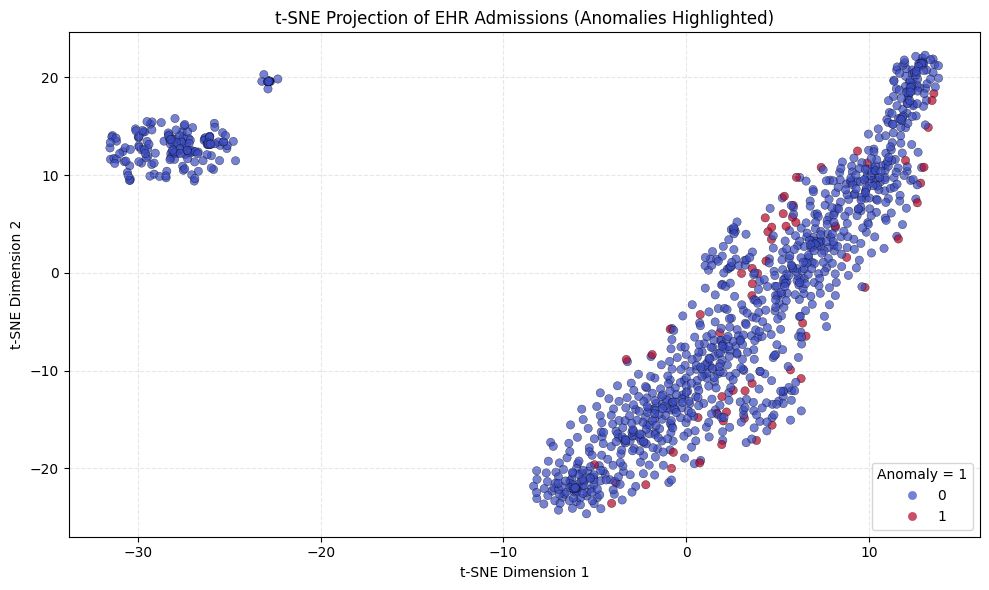

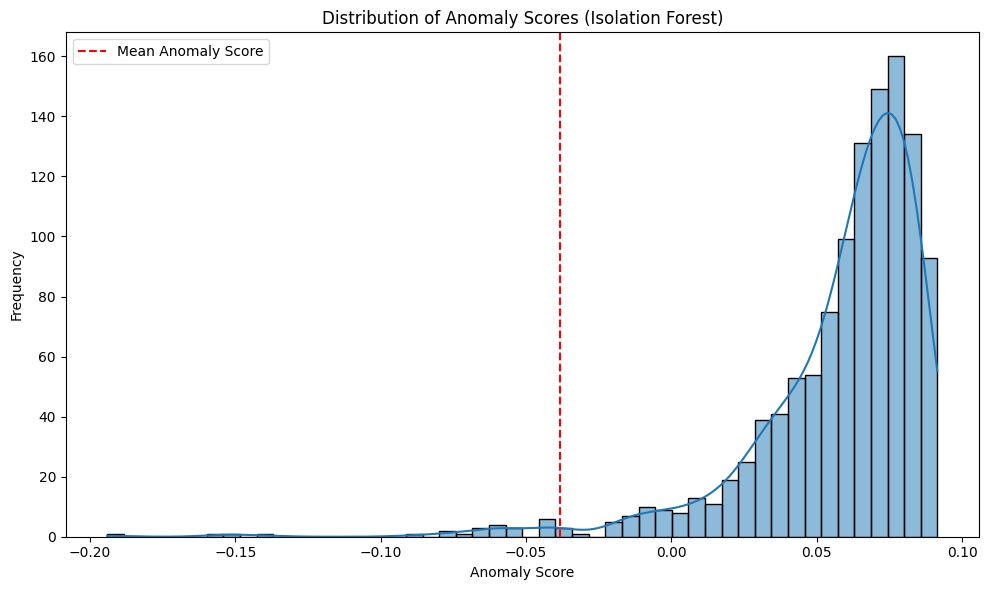

Detected 59 anomalous admissions.



In [99]:

print("[3] Running Isolation Forest to detect anomalies...")
anomalies = detect_anomalies(df)
print(f"Detected {len(anomalies)} anomalous admissions.\n")


In [25]:
import concurrent.futures

def explain_anomaly_wrapper(hadm_id):
    try:
        explanation = explain_anomaly(hadm_id)
        return hadm_id, explanation
    except Exception as e:
        return hadm_id, f"Error: {e}"

N = int(input("How many top-N anomalies would you like to explain? "))
top_anomalies = anomalies.head(N)

print("[4] Generating explanations for top anomalies...\n")

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = {executor.submit(explain_anomaly_wrapper, row['hadm_id']): row['hadm_id'] for _, row in top_anomalies.iterrows()}
    for future in concurrent.futures.as_completed(futures):
        hadm_id, explanation = future.result(timeout=90)
        print(f"HADM_ID: {hadm_id}")
        print("Explanation:", explanation)
        print("-" * 60)


[4] Generating explanations for top anomalies...

HADM_ID: 164694
Explanation: The hospital admission with HADM_ID 164694 may be clinically anomalous for several reasons:

1. **Diagnosis and Age Mismatch**: The patient is a 38-year-old male diagnosed with Acute Myelogenous Leukemia (AML), which is more commonly diagnosed in older adults. This diagnosis at a relatively young age could be considered unusual and warrants further investigation into potential underlying genetic or environmental factors.

2. **Medication-Diagnosis Combination**: The patient is receiving a wide array of medications, including Quetiapine Fumarate, which is primarily used for psychiatric conditions. This raises concerns about the appropriateness of this medication in the context of AML treatment, as it may not be a standard part of the therapeutic regimen for this diagnosis.

3. **Lab Test Patterns**: The lab results show a notably low platelet count (29.0 K/uL), which is expected in patients with leukemia. How